<a href="https://colab.research.google.com/github/dineshRaja29/EnsembleModels/blob/main/EnsembleModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##<font color='green'><b>INTRODUCTION</b></font>

There are primarly four Ensemble techniques


*   Bagging
*   Boosting
*   Stacking
*   Cascading

Popular implementation of Bagging and Boosting techniques with some modification are Random Forest and Gradient Boosting Decision Tree respectively.




##<font color='green'><b>OBJECTIVE</b></font>



Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2) using Bagging and Boosting.


##<font color='green'><b>DATASET LOADING AND CLEANING</b></font>

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


Note: We could use Score/Rating. A rating of 4 or 5 can be considered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review. Thus we are not using score and rating column. We will try to solve this using Bagging and Boosting algorithm




The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import sys
print(sys.version)

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]


In [ ]:
# using SQLite Table to read data.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from PIL import Image

con = sqlite3.connect('/content/drive/My Drive/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [ ]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [ ]:
display['COUNT(*)'].sum()

393063

<font color='green'><b>Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<font color='green'><b>Observation:-</b></font> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

<font color='green'><b>Preprocessing Review Text</b></font>

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:34<00:00, 2522.98it/s]


In [ ]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

##<font color='green'><b>BAGGING: RANDOM FOREST

In [ ]:
from sklearn.model_selection import GridSearchCV
import seaborn as sns 
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
import xgboost as xgb

<font color='green'><b>Common Functions

In [ ]:
# Confusion matrix print function 
def ConfusionMatrixPrint(cm):
  class_label = ["negative", "positive"]
  df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
  sns.heatmap(df_cm, annot = True, fmt = "d")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()
  
def ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr):
  plt.figure()
  plt.plot(fpr, tpr,label='Test ROC curve' ,
           color='darkorange', linestyle=':', linewidth=4)

  plt.plot(fpr_tr, tpr_tr,label='Train ROC curve',
           color='navy', linestyle=':', linewidth=4)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC CURVE ')
  plt.legend(loc="lower right")
  plt.show()

max_depth = [1, 5, 10, 50, 100, 500, 1000]
n_estimators = [1, 2, 4, 8, 16, 32, 64, 128, 256]
param_grid =  { 'max_depth' : max_depth,
           'n_estimators': n_estimators}
print("---- Parameter Grid is ------\n", param_grid)

---- Parameter Grid is ------
 {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128, 256]}


<font color='green'><b>Data Splitting

In [ ]:
X = preprocessed_reviews
y = final['Score']
# Random Splitting of data using train_test_split
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.3, random_state=0)



In [ ]:
training_words = []
for sentance in X_tr:
    training_words.append(sentance.split())
w2v_model=Word2Vec(training_words,min_count=5,size=50, workers=4)


In [ ]:
w2v_words = list(w2v_model.wv.vocab)
X_tr_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# print(w2v_model.wv.vocab)
for sent in (training_words): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_tr_vectors.append(sent_vec)


In [ ]:
test_words = []
for sentance in X_test:
    test_words.append(sentance.split())

X_test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# print(w2v_model.wv.vocab)
for sent in test_words: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_vectors.append(sent_vec)

In [ ]:
# Please write all the code with proper documentation
training_words = []
for sentance in X_tr:
    training_words.append(sentance.split())
w2v_model=Word2Vec(training_words,min_count=5,size=50, workers=4)


In [ ]:
w2v_words = list(w2v_model.wv.vocab)


In [ ]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


In [ ]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names


In [ ]:
list_of_sentance_tr=[]
for sentance in X_tr:
    list_of_sentance_tr.append(sentance.split())

tfidf_sent_vectors_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_tr): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tr.append(sent_vec)
    row += 1

100%|██████████| 61441/61441 [34:09<00:00, 31.39it/s]


In [ ]:
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 26332/26332 [14:52<00:00, 29.51it/s]


###<font color='green'><b><font color='green'><b>Text Encoding using BOW

In [ ]:
vectorizer =  CountVectorizer()
# learning the vocabulary 
vectorizer.fit(X_tr)
# transforming the data according to the learning vocabulary
train_data = vectorizer.transform(X_tr)
test_data = vectorizer.transform(X_test)

In [ ]:
rf = RandomForestClassifier(class_weight = 'balanced')
clf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                   scoring = 'roc_auc', cv = 3, 
                   return_train_score = True)
clf.fit(train_data, y_tr)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

In [ ]:
print('Best depth:', clf.best_estimator_.get_params()['max_depth'])
print('Best n_estimators:', clf.best_estimator_.get_params()['n_estimators'])


Best depth: 500
Best n_estimators: 256


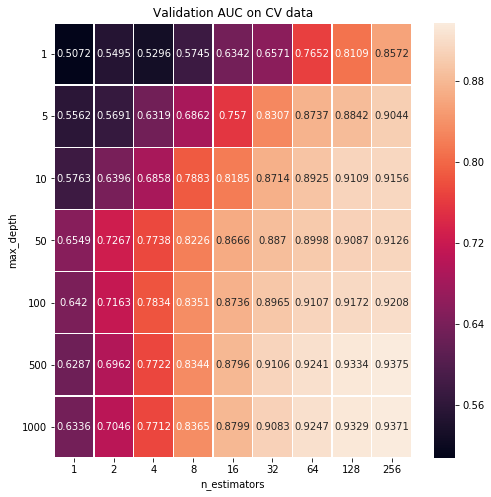

In [ ]:
scores = clf.cv_results_['mean_test_score'].reshape(
                                                     len(param_grid['max_depth']), len(param_grid['n_estimators']))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(scores, linewidths=.5, fmt='.4g',annot=True,  
                 xticklabels = n_estimators, 
                 yticklabels = max_depth)
plt.ylabel('max_depth')
plt.xlabel('n_estimators')
plt.yticks(rotation=0)
plt.title('Validation AUC on CV data')
plt.show()

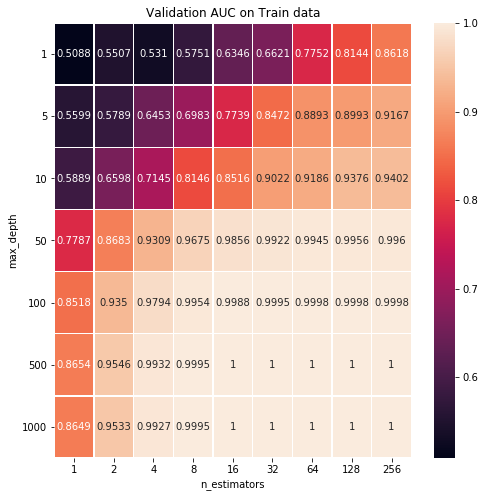

In [ ]:
scores = clf.cv_results_['mean_train_score'].reshape(
                                                     len(param_grid['max_depth']), len(param_grid['n_estimators']))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(scores, linewidths=.5, fmt='.4g',annot=True,  
                 xticklabels = n_estimators, 
                 yticklabels = max_depth)
plt.ylabel('max_depth')
plt.xlabel('n_estimators')
plt.yticks(rotation=0)
plt.title('Validation AUC on Train data')
plt.show()

In [ ]:
print("\n Train Score **\n")
print(clf.cv_results_['mean_train_score'].reshape(len(param_grid['max_depth']), len(param_grid['n_estimators'])))
print("\n CV Score **\n")
print(clf.cv_results_['mean_test_score'].reshape(len(param_grid['max_depth']), len(param_grid['n_estimators'])))



 Train Score **

[[0.50877783 0.55067221 0.53096709 0.57514085 0.63464759 0.66214277
  0.77522609 0.81439462 0.8618056 ]
 [0.5599328  0.57889538 0.64525648 0.69831764 0.77386445 0.84716206
  0.88931783 0.89934706 0.91666292]
 [0.5888877  0.65981096 0.7144992  0.81458069 0.85162949 0.9022314
  0.91858495 0.93764165 0.94021556]
 [0.77872246 0.86831441 0.93090521 0.96752091 0.9855958  0.9921878
  0.99446337 0.99563063 0.99599745]
 [0.85175034 0.93502966 0.97941473 0.99538602 0.99884281 0.99953845
  0.99977324 0.99982166 0.99983687]
 [0.86535199 0.95464589 0.99323813 0.99949918 0.9999887  0.99999237
  0.999997   0.99999753 0.99999755]
 [0.86488357 0.95329083 0.99266576 0.99951702 0.99997841 0.9999933
  0.99999694 0.99999748 0.99999749]]

 CV Score **

[[0.50717091 0.54949644 0.52960816 0.57445287 0.63416317 0.65710823
  0.76520678 0.81088902 0.8572011 ]
 [0.55623578 0.56907353 0.63185288 0.68622547 0.75702267 0.83066366
  0.87365834 0.88421205 0.90438508]
 [0.57632102 0.63958204 0.6858093

In [ ]:
rf = RandomForestClassifier(class_weight = 'balanced', max_depth = 500, n_estimators = 256)

In [ ]:
rf.fit(train_data, y_tr)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=256, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

Confusion Matrix of train data 



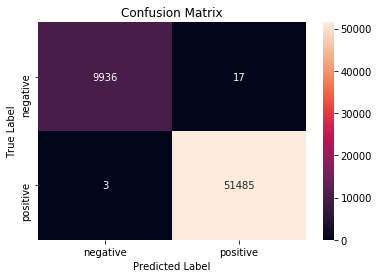

Confusion Matrix of test data 



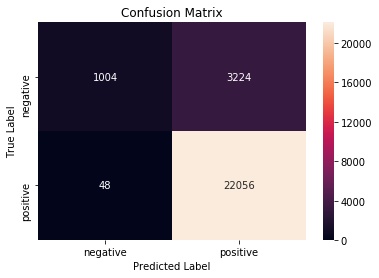

**** TEST AUC ***  0.9342857823393396
**** TRAIN AUC *****  0.9897850391323373


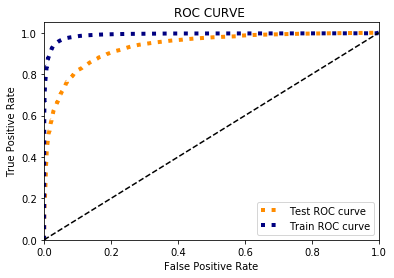

In [ ]:
print("Confusion Matrix of train data \n")
predict = rf.predict(train_data)
cm = metrics.confusion_matrix(y_tr, predict)
ConfusionMatrixPrint(cm)
print("Confusion Matrix of test data \n")
predict = rf.predict(test_data)
cm = metrics.confusion_matrix(y_test, predict)
ConfusionMatrixPrint(cm)
y_cv_predict = np.array(rf.predict_proba(test_data))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(rf.predict_proba(train_data))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

<font color='green'><b>Top 20 important features

In [ ]:
# Please write all the code with proper documentation
pos = {}
neg = {}
feature_names = vectorizer.get_feature_names()
coefs_with_fns = sorted(zip(rf.feature_importances_, feature_names))
top = zip(coefs_with_fns[:20], coefs_with_fns[:-(20+ 1):-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print ("\t%.4f\t%-15s\t\t%.4f\t%-15s"% (coef_1, fn_1, coef_2, fn_2))
    pos[fn_1] = float(coef_1) + 0.000001 # to avoid ZeroDivisionError: float division by zero
    neg[fn_2] = float(coef_2) + 0.000001 # to avoid ZeroDivisionError: float division by zero

	0.0000	aaaaa          		0.0236	not            
	0.0000	aaaaaawwwwwwwwww		0.0175	great          
	0.0000	aaaah          		0.0084	best           
	0.0000	aadp           		0.0083	love           
	0.0000	aaf            		0.0067	disappointed   
	0.0000	aah            		0.0065	delicious      
	0.0000	ab             		0.0055	good           
	0.0000	abbey          		0.0054	bad            
	0.0000	abbreviation   		0.0051	would          
	0.0000	abhors         		0.0050	perfect        
	0.0000	abilling       		0.0048	loves          
	0.0000	abita          		0.0044	product        
	0.0000	ablaze         		0.0043	money          
	0.0000	ablution       		0.0042	thought        
	0.0000	abode          		0.0039	taste          
	0.0000	abor           		0.0037	favorite       
	0.0000	abosrb         		0.0036	excellent      
	0.0000	abosutely      		0.0036	highly         
	0.0000	abottle        		0.0035	like           
	0.0000	abou           		0.0034	awful          


<font color='green'><b>Positive Class word Cloud

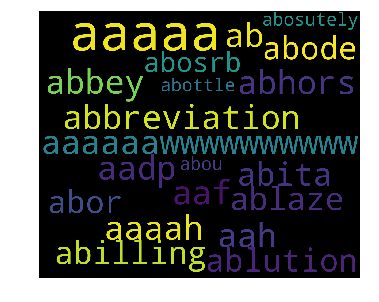

In [ ]:
wordcloud = WordCloud(    background_color = 'black',
                          width = 1200,
                          height = 1000,
                    ).generate_from_frequencies(pos)

fig = plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("pos.png")
plt.show()


<font color='green'><b>Negative Class word Cloud

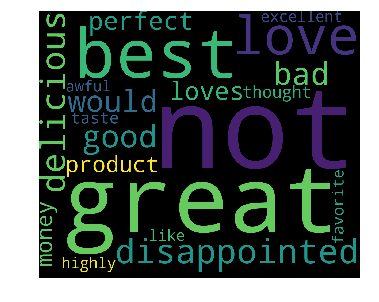

In [ ]:
wordcloud = WordCloud(    background_color = 'black',
                          width = 1200,
                          height = 1000,
                    ).generate_from_frequencies(neg)

fig = plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("neg.png")
plt.show()


###<font color='green'><b>Text Encoding using TFIDF

In [ ]:
vectorizer =  TfidfVectorizer()
# learning the vocabulary 
vectorizer.fit(X_tr)
# transforming the data according to the learning vocabulary
train_data = vectorizer.transform(X_tr)
test_data = vectorizer.transform(X_test)

In [ ]:
rf = RandomForestClassifier(class_weight = 'balanced')
clf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                   scoring = 'roc_auc', cv = 3, 
                   return_train_score = True)
clf.fit(train_data, y_tr)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

In [ ]:
print('Best depth:', clf.best_estimator_.get_params()['max_depth'])
print('Best n_estimators:', clf.best_estimator_.get_params()['n_estimators'])


Best depth: 500
Best n_estimators: 256


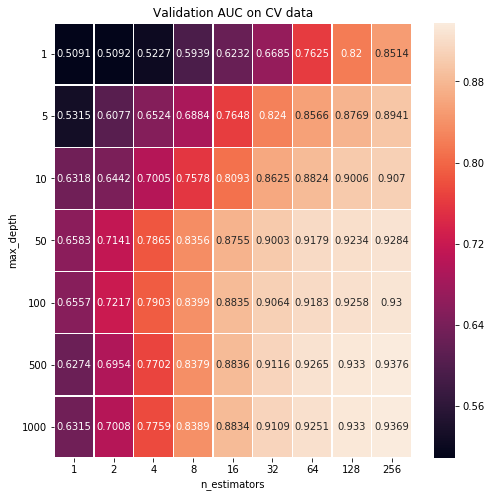

In [ ]:
scores = clf.cv_results_['mean_test_score'].reshape(
                                                     len(param_grid['max_depth']), len(param_grid['n_estimators']))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(scores, linewidths=.5, fmt='.4g',annot=True,  
                 xticklabels = n_estimators, 
                 yticklabels = max_depth)
plt.ylabel('max_depth')
plt.xlabel('n_estimators')
plt.yticks(rotation=0)
plt.title('Validation AUC on CV data')
plt.show()

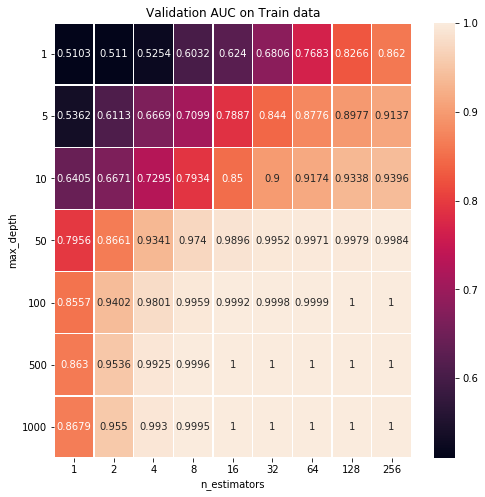

In [ ]:
scores = clf.cv_results_['mean_train_score'].reshape(
                                                     len(param_grid['max_depth']), len(param_grid['n_estimators']))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(scores, linewidths=.5, fmt='.4g',annot=True,  
                 xticklabels = n_estimators, 
                 yticklabels = max_depth)
plt.ylabel('max_depth')
plt.xlabel('n_estimators')
plt.yticks(rotation=0)
plt.title('Validation AUC on Train data')
plt.show()

In [ ]:
print("\n Train Score **\n")
print(clf.cv_results_['mean_train_score'].reshape(len(param_grid['max_depth']), len(param_grid['n_estimators'])))
print("\n CV Score **\n")
print(clf.cv_results_['mean_test_score'].reshape(len(param_grid['max_depth']), len(param_grid['n_estimators'])))



 Train Score **

[[0.51034763 0.5109985  0.52543458 0.60324786 0.62399304 0.68059635
  0.76830755 0.8265772  0.86204809]
 [0.53619433 0.61129966 0.66689209 0.70987543 0.78871906 0.84401845
  0.87764605 0.89767793 0.91373879]
 [0.64054122 0.66707793 0.72953427 0.79339732 0.84997834 0.90003672
  0.91740643 0.93379917 0.9395954 ]
 [0.79556939 0.86607    0.93406274 0.97402085 0.98963701 0.99517229
  0.99711969 0.99788697 0.99842011]
 [0.85565852 0.94017641 0.98009886 0.99590451 0.99923445 0.99979102
  0.99991883 0.99995045 0.99995967]
 [0.86303217 0.95361159 0.9924831  0.99959395 0.9999827  0.99999434
  0.99999646 0.99999735 0.99999762]
 [0.86785822 0.95504335 0.99300344 0.99952419 0.99997936 0.99999685
  0.99999611 0.99999741 0.99999764]]

 CV Score **

[[0.5090835  0.50924866 0.52271589 0.59392089 0.62324167 0.66853902
  0.76247172 0.82002728 0.85142572]
 [0.53148487 0.6076713  0.65241218 0.68836463 0.76475174 0.82401966
  0.85660117 0.87691058 0.89413467]
 [0.63175018 0.64421685 0.7004

In [ ]:
rf = RandomForestClassifier(class_weight = 'balanced', 
                            max_depth = clf.best_estimator_.get_params()['max_depth'], 
                            n_estimators = clf.best_estimator_.get_params()['n_estimators']
                           )

In [ ]:
rf.fit(train_data, y_tr)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=256, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

Confusion Matrix of train data 



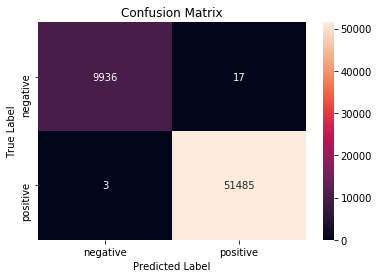

Confusion Matrix of test data 



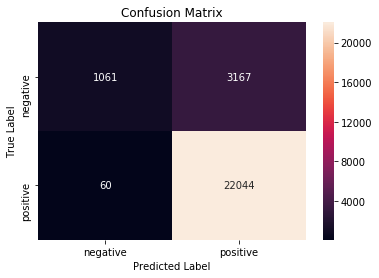

**** TEST AUC ***  0.9336671898663615
**** TRAIN AUC *****  0.9890766805196356


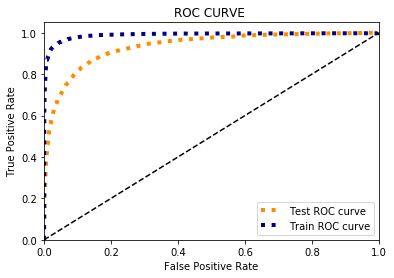

In [ ]:
print("Confusion Matrix of train data \n")
predict = rf.predict(train_data)
cm = metrics.confusion_matrix(y_tr, predict)
ConfusionMatrixPrint(cm)
print("Confusion Matrix of test data \n")
predict = rf.predict(test_data)
cm = metrics.confusion_matrix(y_test, predict)
ConfusionMatrixPrint(cm)
y_cv_predict = np.array(rf.predict_proba(test_data))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(rf.predict_proba(train_data))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

<font color='green'><b>Top 20 important features

In [ ]:
# Please write all the code with proper documentation
pos = {}
neg = {}
feature_names = vectorizer.get_feature_names()
coefs_with_fns = sorted(zip(rf.feature_importances_, feature_names))
top = zip(coefs_with_fns[:20], coefs_with_fns[:-(20+ 1):-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print ("\t%.4f\t%-15s\t\t%.4f\t%-15s"% (coef_1, fn_1, coef_2, fn_2))
    pos[fn_1] = float(coef_1) + 0.000001 # to avoid ZeroDivisionError: float division by zero
    neg[fn_2] = float(coef_2) + 0.000001 # to avoid ZeroDivisionError: float division by zero

	0.0000	aaaaaaaaaaaaaaa		0.0236	not            
	0.0000	aaaaaaahhhhhh  		0.0204	great          
	0.0000	aaaaaawwwwwwwwww		0.0102	love           
	0.0000	aaaaah         		0.0095	best           
	0.0000	aaaah          		0.0075	delicious      
	0.0000	aadp           		0.0075	good           
	0.0000	aaf            		0.0061	perfect        
	0.0000	aahs           		0.0057	bad            
	0.0000	abates         		0.0057	disappointed   
	0.0000	abbey          		0.0056	loves          
	0.0000	abbreviated    		0.0054	would          
	0.0000	abbreviation   		0.0047	favorite       
	0.0000	abe            		0.0045	money          
	0.0000	abhors         		0.0044	taste          
	0.0000	abig           		0.0041	product        
	0.0000	abita          		0.0041	nice           
	0.0000	ablity         		0.0041	thought        
	0.0000	ablution       		0.0039	like           
	0.0000	abnoxious      		0.0038	excellent      
	0.0000	aboard         		0.0038	find           


<font color='green'><b>Positive Class word Cloud

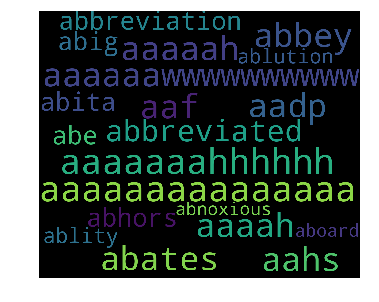

In [ ]:
wordcloud = WordCloud(    background_color = 'black',
                          width = 1200,
                          height = 1000,
                    ).generate_from_frequencies(pos)

fig = plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("pos.png")
plt.show()


<font color='green'><b>Negative Class word Cloud

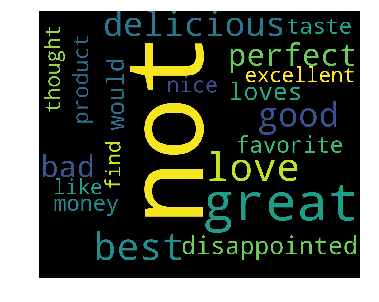

In [ ]:
wordcloud = WordCloud(    background_color = 'black',
                          width = 1200,
                          height = 1000,
                    ).generate_from_frequencies(neg)

fig = plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("neg.png")
plt.show()


###<font color='green'><b>Text Encoding using AVG W2V

In [ ]:
rf = RandomForestClassifier(class_weight = 'balanced')
clf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                   scoring = 'roc_auc', cv = 3, 
                   return_train_score = True)
clf.fit(X_tr_vectors, y_tr)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

In [ ]:
print('Best depth:', clf.best_estimator_.get_params()['max_depth'])
print('Best n_estimators:', clf.best_estimator_.get_params()['n_estimators'])


Best depth: 500
Best n_estimators: 256


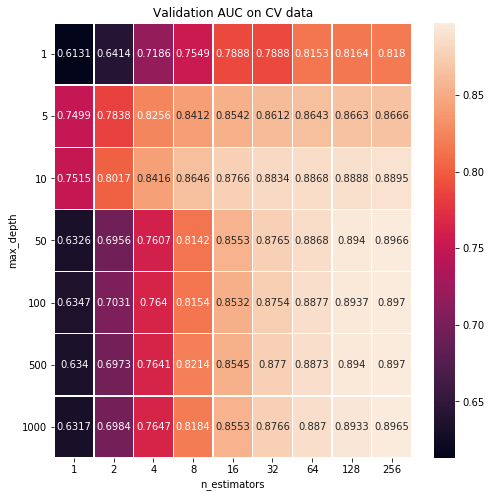

In [ ]:
scores = clf.cv_results_['mean_test_score'].reshape(
                                                     len(param_grid['max_depth']), len(param_grid['n_estimators']))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(scores, linewidths=.5, fmt='.4g',annot=True,  
                 xticklabels = n_estimators, 
                 yticklabels = max_depth)
plt.ylabel('max_depth')
plt.xlabel('n_estimators')
plt.yticks(rotation=0)
plt.title('Validation AUC on CV data')
plt.show()

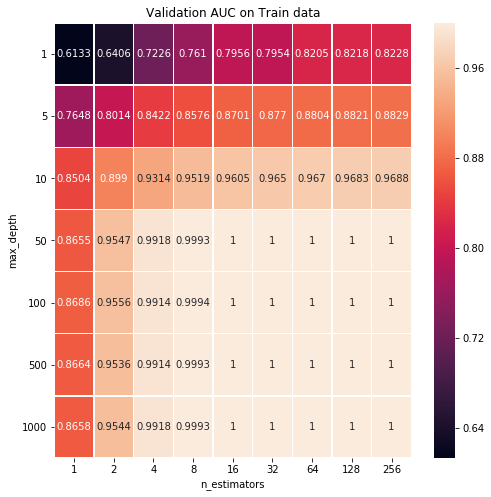

In [ ]:
scores = clf.cv_results_['mean_train_score'].reshape(
                                                     len(param_grid['max_depth']), len(param_grid['n_estimators']))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(scores, linewidths=.5, fmt='.4g',annot=True,  
                 xticklabels = n_estimators, 
                 yticklabels = max_depth)
plt.ylabel('max_depth')
plt.xlabel('n_estimators')
plt.yticks(rotation=0)
plt.title('Validation AUC on Train data')
plt.show()

In [ ]:
print("\n Train Score **\n")
print(clf.cv_results_['mean_train_score'].reshape(len(param_grid['max_depth']), len(param_grid['n_estimators'])))
print("\n CV Score **\n")
print(clf.cv_results_['mean_test_score'].reshape(len(param_grid['max_depth']), len(param_grid['n_estimators'])))



 Train Score **

[[0.61327487 0.6405601  0.72256112 0.76097523 0.79563432 0.79539239
  0.82051607 0.82176573 0.82283153]
 [0.76477274 0.80135134 0.84221976 0.85757601 0.87011246 0.87698652
  0.88041799 0.88213999 0.88290038]
 [0.85039724 0.89902304 0.93142431 0.95186745 0.96048171 0.96498197
  0.96701775 0.96833674 0.96879786]
 [0.86547006 0.95473655 0.99182374 0.99928822 0.9999576  0.999993
  0.99999697 0.99999752 0.99999745]
 [0.86857329 0.9555887  0.99144742 0.99939328 0.99995135 0.99998908
  0.99999614 0.99999656 0.99999755]
 [0.86639852 0.953645   0.99139028 0.999296   0.99995984 0.99999398
  0.99999579 0.99999708 0.99999752]
 [0.86580843 0.95443569 0.9917965  0.99928821 0.99995494 0.99999061
  0.99999715 0.99999718 0.99999754]]

 CV Score **

[[0.61308515 0.64142225 0.71862795 0.75494273 0.78880734 0.78879454
  0.81530498 0.81636837 0.8180341 ]
 [0.74993569 0.78380653 0.82563431 0.84117687 0.85418342 0.86122246
  0.8642998  0.86631309 0.86663962]
 [0.75146072 0.80168706 0.841579

In [ ]:
rf = RandomForestClassifier(class_weight = 'balanced', 
                            max_depth = clf.best_estimator_.get_params()['max_depth'], 
                            n_estimators = clf.best_estimator_.get_params()['n_estimators']
                           )

In [ ]:
rf.fit(X_tr_vectors, y_tr)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=256, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

Confusion Matrix of train data 



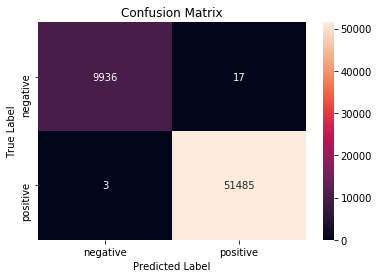

Confusion Matrix of test data 



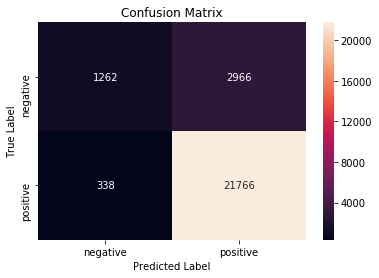

**** TEST AUC ***  0.8833149331739082
**** TRAIN AUC *****  0.9725626063614589


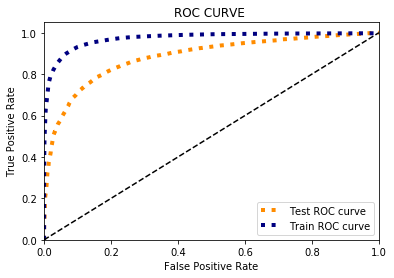

In [ ]:
print("Confusion Matrix of train data \n")
predict = rf.predict(X_tr_vectors)
cm = metrics.confusion_matrix(y_tr, predict)
ConfusionMatrixPrint(cm)
print("Confusion Matrix of test data \n")
predict = rf.predict(X_test_vectors)
cm = metrics.confusion_matrix(y_test, predict)
ConfusionMatrixPrint(cm)
y_cv_predict = np.array(rf.predict_proba(X_test_vectors))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(rf.predict_proba(X_tr_vectors))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

###<font color='green'><b>Text Encoding using TFIDF W2V

In [ ]:
# Please write all the code with proper documentation

In [ ]:
rf = RandomForestClassifier(class_weight = 'balanced')
clf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                   scoring = 'roc_auc', cv = 3, 
                   return_train_score = True)
clf.fit(tfidf_sent_vectors_tr, y_tr)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

In [ ]:
print('Best depth:', clf.best_estimator_.get_params()['max_depth'])
print('Best n_estimators:', clf.best_estimator_.get_params()['n_estimators'])


Best depth: 100
Best n_estimators: 256


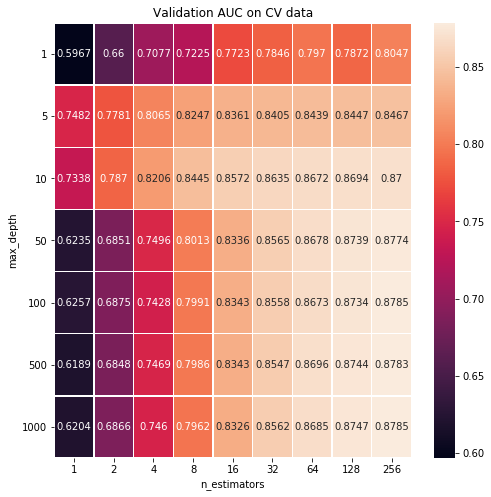

In [ ]:
scores = clf.cv_results_['mean_test_score'].reshape(
                                                     len(param_grid['max_depth']), len(param_grid['n_estimators']))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(scores, linewidths=.5, fmt='.4g',annot=True,  
                 xticklabels = n_estimators, 
                 yticklabels = max_depth)
plt.ylabel('max_depth')
plt.xlabel('n_estimators')
plt.yticks(rotation=0)
plt.title('Validation AUC on CV data')
plt.show()

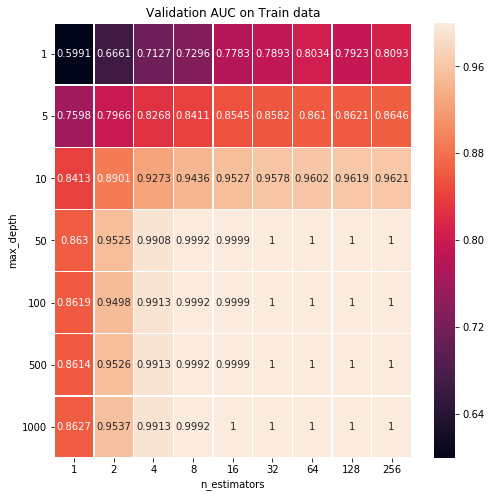

In [ ]:
scores = clf.cv_results_['mean_train_score'].reshape(
                                                     len(param_grid['max_depth']), len(param_grid['n_estimators']))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(scores, linewidths=.5, fmt='.4g',annot=True,  
                 xticklabels = n_estimators, 
                 yticklabels = max_depth)
plt.ylabel('max_depth')
plt.xlabel('n_estimators')
plt.yticks(rotation=0)
plt.title('Validation AUC on Train data')
plt.show()

In [ ]:
print("\n Train Score **\n")
print(clf.cv_results_['mean_train_score'].reshape(len(param_grid['max_depth']), len(param_grid['n_estimators'])))
print("\n CV Score **\n")
print(clf.cv_results_['mean_test_score'].reshape(len(param_grid['max_depth']), len(param_grid['n_estimators'])))



 Train Score **

[[0.59914484 0.66611779 0.71265944 0.7295687  0.77828192 0.78934089
  0.8034418  0.79232388 0.8092971 ]
 [0.75984523 0.79659362 0.82676749 0.84109018 0.85450674 0.85816799
  0.86101886 0.8621451  0.86460336]
 [0.84126368 0.89011506 0.9272888  0.94364688 0.95272269 0.95784284
  0.96017063 0.96190915 0.96205948]
 [0.86298699 0.95252337 0.9908157  0.99915833 0.99994606 0.999992
  0.99999711 0.99999612 0.99999746]
 [0.86189559 0.94983702 0.99125462 0.99924753 0.99993911 0.99999295
  0.99999575 0.99999701 0.99999759]
 [0.86141924 0.95255326 0.99128848 0.9991864  0.99994382 0.9999932
  0.99999712 0.99999715 0.9999975 ]
 [0.86269719 0.95372393 0.9912565  0.99915943 0.99995088 0.99998826
  0.99999707 0.9999971  0.99999752]]

 CV Score **

[[0.59673401 0.66001464 0.70769745 0.72245121 0.77234922 0.78461694
  0.79695325 0.78718344 0.80468902]
 [0.74815141 0.77813777 0.80649551 0.82470302 0.83610617 0.84047635
  0.84391112 0.84470458 0.84669542]
 [0.73377492 0.78704274 0.8206175

In [ ]:
rf = RandomForestClassifier(class_weight = 'balanced', 
                            max_depth = clf.best_estimator_.get_params()['max_depth'], 
                            n_estimators = clf.best_estimator_.get_params()['n_estimators']
                           )

In [ ]:
rf.fit(tfidf_sent_vectors_tr, y_tr)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=256, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

Confusion Matrix of train data 



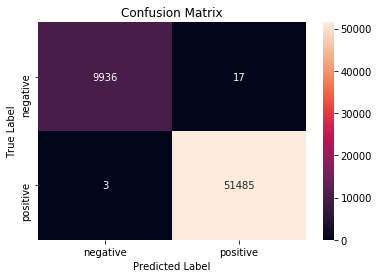

Confusion Matrix of test data 



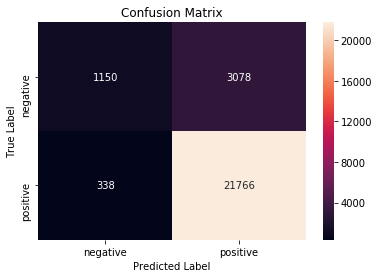

**** TEST AUC ***  0.8636541231423074
**** TRAIN AUC *****  0.9721205436215223


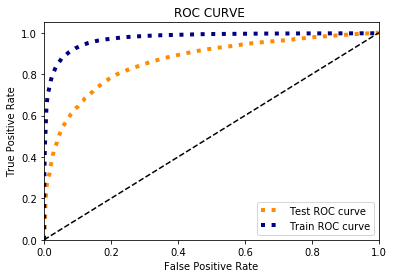

In [ ]:
print("Confusion Matrix of train data \n")
predict = rf.predict(tfidf_sent_vectors_tr)
cm = metrics.confusion_matrix(y_tr, predict)
ConfusionMatrixPrint(cm)
print("Confusion Matrix of test data \n")
predict = rf.predict(tfidf_sent_vectors_test)
cm = metrics.confusion_matrix(y_test, predict)
ConfusionMatrixPrint(cm)
y_cv_predict = np.array(rf.predict_proba(tfidf_sent_vectors_test))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(rf.predict_proba(tfidf_sent_vectors_tr))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

##<font color='green'><b>BOOSTING: GBDT (using XGBOOST)

###<font color='green'><b>Text Encoding using BOW

In [ ]:
vectorizer =  CountVectorizer()
# learning the vocabulary 
vectorizer.fit(X_tr)
# transforming the data according to the learning vocabulary
train_data = vectorizer.transform(X_tr)
test_data = vectorizer.transform(X_test)

In [ ]:
rf = xgb.XGBClassifier(class_weight = 'balanced')
clf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                   scoring = 'roc_auc', cv = 3, 
                   return_train_score = True)
clf.fit(train_data, y_tr)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     class_weight='balanced',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000],
                         'n_estimat

In [ ]:
print('Best depth:', clf.best_estimator_.get_params()['max_depth'])
print('Best n_estimators:', clf.best_estimator_.get_params()['n_estimators'])


Best depth: 50
Best n_estimators: 256


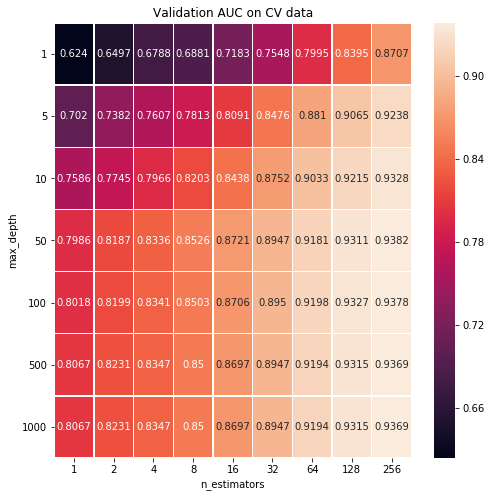

In [ ]:
scores = clf.cv_results_['mean_test_score'].reshape(
                                                     len(param_grid['max_depth']), len(param_grid['n_estimators']))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(scores, linewidths=.5, fmt='.4g',annot=True,  
                 xticklabels = n_estimators, 
                 yticklabels = max_depth)
plt.ylabel('max_depth')
plt.xlabel('n_estimators')
plt.yticks(rotation=0)
plt.title('Validation AUC on CV data')
plt.show()

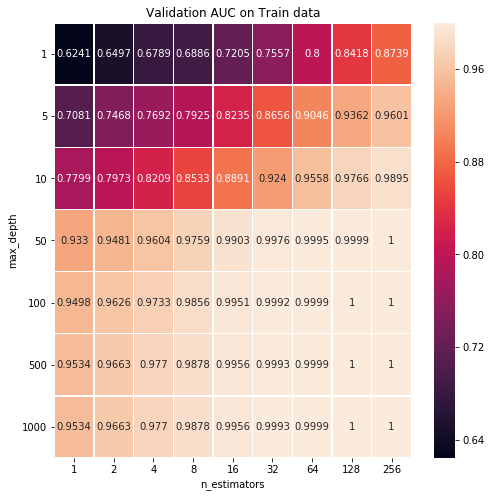

In [ ]:
scores = clf.cv_results_['mean_train_score'].reshape(
                                                     len(param_grid['max_depth']), len(param_grid['n_estimators']))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(scores, linewidths=.5, fmt='.4g',annot=True,  
                 xticklabels = n_estimators, 
                 yticklabels = max_depth)
plt.ylabel('max_depth')
plt.xlabel('n_estimators')
plt.yticks(rotation=0)
plt.title('Validation AUC on Train data')
plt.show()

In [ ]:
print("\n Train Score **\n")
print(clf.cv_results_['mean_train_score'].reshape(len(param_grid['max_depth']), len(param_grid['n_estimators'])))
print("\n CV Score **\n")
print(clf.cv_results_['mean_test_score'].reshape(len(param_grid['max_depth']), len(param_grid['n_estimators'])))



 Train Score **

[[0.62412541 0.64969643 0.67888048 0.68863251 0.72046092 0.75568387
  0.79995067 0.84182109 0.87394169]
 [0.70813352 0.74678372 0.76923903 0.79253837 0.82348872 0.86559103
  0.90458465 0.936154   0.96013983]
 [0.77991459 0.79731639 0.8208871  0.8533366  0.88909329 0.92400055
  0.95584505 0.97661002 0.98947564]
 [0.9330396  0.9481121  0.96043434 0.9758989  0.99034216 0.99757076
  0.99945974 0.99989215 0.99997718]
 [0.94977568 0.96261402 0.97329399 0.98560101 0.99505268 0.99916365
  0.99990694 0.99997758 0.99999431]
 [0.95336745 0.9662604  0.97698682 0.98782144 0.99558461 0.99927434
  0.99994551 0.99998848 0.99999609]
 [0.95336745 0.9662604  0.97698682 0.98782144 0.99558461 0.99927434
  0.99994551 0.99998848 0.99999609]]

 CV Score **

[[0.62404624 0.64967327 0.67883869 0.68806776 0.71833561 0.75483796
  0.7994728  0.83952846 0.87065831]
 [0.70196286 0.73823685 0.7607182  0.78128774 0.80909722 0.84758667
  0.88095429 0.90645378 0.92384774]
 [0.75862127 0.77454214 0.7965

In [ ]:
rf = xgb.XGBClassifier(class_weight = 'balanced', 
                       max_depth = clf.best_estimator_.get_params()['max_depth']
                       , n_estimators = clf.best_estimator_.get_params()['n_estimators'])

In [ ]:
rf.fit(train_data, y_tr)

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=256, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Confusion Matrix of train data 



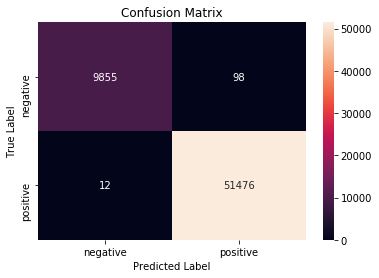

Confusion Matrix of test data 



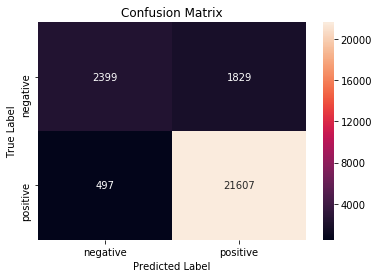

**** TEST AUC ***  0.8412213316613543
**** TRAIN AUC *****  0.849020740472764


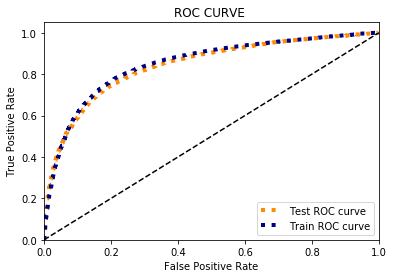

In [ ]:
print("Confusion Matrix of train data \n")
predict = rf.predict(train_data)
cm = metrics.confusion_matrix(y_tr, predict)
ConfusionMatrixPrint(cm)
print("Confusion Matrix of test data \n")
predict = rf.predict(test_data)
cm = metrics.confusion_matrix(y_test, predict)
ConfusionMatrixPrint(cm)
y_cv_predict = np.array(rf.predict_proba(test_data))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(rf.predict_proba(train_data))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

###<font color='green'><b>Text Encoding using TFIDF

In [ ]:
vectorizer =  TfidfVectorizer()
# learning the vocabulary 
vectorizer.fit(X_tr)
# transforming the data according to the learning vocabulary
train_data = vectorizer.transform(X_tr)
test_data = vectorizer.transform(X_test)

In [ ]:
rf = xgb.XGBClassifier(class_weight = 'balanced')
clf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                   scoring = 'roc_auc', cv = 3, 
                   return_train_score = True)
clf.fit(train_data, y_tr)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     class_weight='balanced',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000],
                         'n_estimat

In [ ]:
print('Best depth:', clf.best_estimator_.get_params()['max_depth'])
print('Best n_estimators:', clf.best_estimator_.get_params()['n_estimators'])


Best depth: 50
Best n_estimators: 256


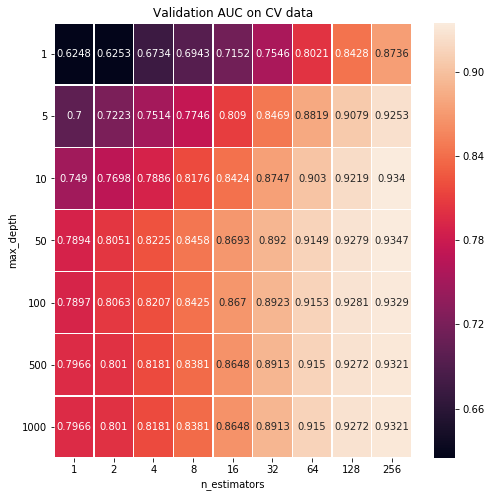

In [ ]:
scores = clf.cv_results_['mean_test_score'].reshape(
                                                     len(param_grid['max_depth']), len(param_grid['n_estimators']))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(scores, linewidths=.5, fmt='.4g',annot=True,  
                 xticklabels = n_estimators, 
                 yticklabels = max_depth)
plt.ylabel('max_depth')
plt.xlabel('n_estimators')
plt.yticks(rotation=0)
plt.title('Validation AUC on CV data')
plt.show()

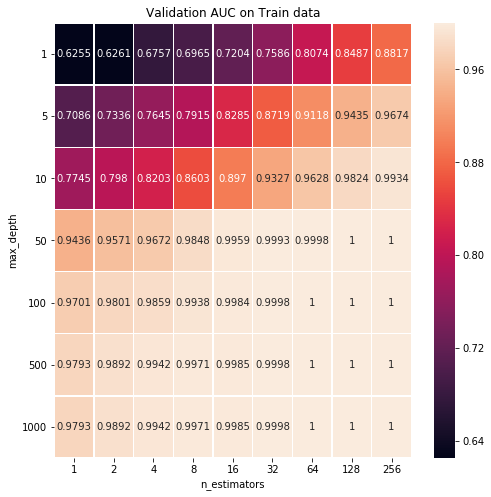

In [ ]:
scores = clf.cv_results_['mean_train_score'].reshape(
                                                     len(param_grid['max_depth']), len(param_grid['n_estimators']))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(scores, linewidths=.5, fmt='.4g',annot=True,  
                 xticklabels = n_estimators, 
                 yticklabels = max_depth)
plt.ylabel('max_depth')
plt.xlabel('n_estimators')
plt.yticks(rotation=0)
plt.title('Validation AUC on Train data')
plt.show()

In [ ]:
print("\n Train Score **\n")
print(clf.cv_results_['mean_train_score'].reshape(len(param_grid['max_depth']), len(param_grid['n_estimators'])))
print("\n CV Score **\n")
print(clf.cv_results_['mean_test_score'].reshape(len(param_grid['max_depth']), len(param_grid['n_estimators'])))



 Train Score **

[[0.62550955 0.62611124 0.67566367 0.69649789 0.72043926 0.75855337
  0.80738565 0.84874861 0.88169061]
 [0.7085691  0.73359057 0.76451837 0.79149377 0.82853862 0.87189227
  0.91184724 0.9435461  0.96735193]
 [0.77446798 0.79800255 0.82034298 0.86030402 0.89704083 0.93274304
  0.96277166 0.98241524 0.99340475]
 [0.94361619 0.95707291 0.96722453 0.98476794 0.99585069 0.99926697
  0.99983722 0.99997358 0.99999297]
 [0.97010748 0.98007761 0.98585141 0.99380502 0.99838816 0.99984481
  0.99997328 0.99999302 0.99999699]
 [0.9792588  0.9892451  0.99415589 0.99711567 0.99847533 0.99979734
  0.9999744  0.99999528 0.99999708]
 [0.9792588  0.9892451  0.99415589 0.99711567 0.99847533 0.99979734
  0.9999744  0.99999528 0.99999708]]

 CV Score **

[[0.62480658 0.62533255 0.67341276 0.69427948 0.71515142 0.75456713
  0.80211771 0.84279082 0.87364099]
 [0.70000493 0.72232979 0.75139666 0.7746494  0.8089755  0.84694388
  0.88191531 0.90785135 0.92527582]
 [0.74904645 0.76980967 0.7885

In [ ]:
rf = xgb.XGBClassifier(class_weight = 'balanced', 
                       max_depth = clf.best_estimator_.get_params()['max_depth']
                       , n_estimators = clf.best_estimator_.get_params()['n_estimators'])

In [ ]:
rf.fit(train_data, y_tr)

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=256, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Confusion Matrix of train data 



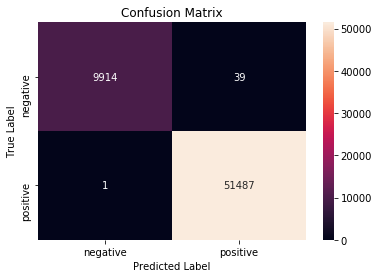

Confusion Matrix of test data 



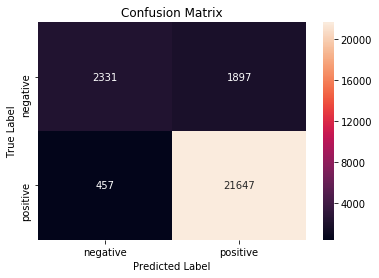

**** TEST AUC ***  0.8475766307360645
**** TRAIN AUC *****  0.8588581382607017


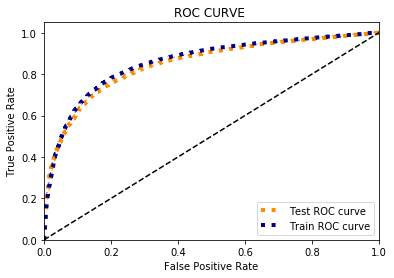

In [ ]:
print("Confusion Matrix of train data \n")
predict = rf.predict(train_data)
cm = metrics.confusion_matrix(y_tr, predict)
ConfusionMatrixPrint(cm)
print("Confusion Matrix of test data \n")
predict = rf.predict(test_data)
cm = metrics.confusion_matrix(y_test, predict)
ConfusionMatrixPrint(cm)
y_cv_predict = np.array(rf.predict_proba(test_data))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(rf.predict_proba(train_data))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

###<font color='green'><b>Text Encoding using AVG W2V

In [ ]:
# Please write all the code with proper documentation
clf = GridSearchCV(estimator = xgb.XGBClassifier(class_weight = 'balanced'), param_grid = param_grid, 
                   scoring = 'roc_auc', cv = 3, 
                   return_train_score = True)
clf.fit(np.array(X_tr_vectors), np.array(y_tr))

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000],
                         'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128, 256]},
             pre_di

In [ ]:
print('Best depth:', clf.best_estimator_.get_params()['max_depth'])
print('Best n_estimators:', clf.best_estimator_.get_params()['n_estimators'])


Best depth: 50
Best n_estimators: 256


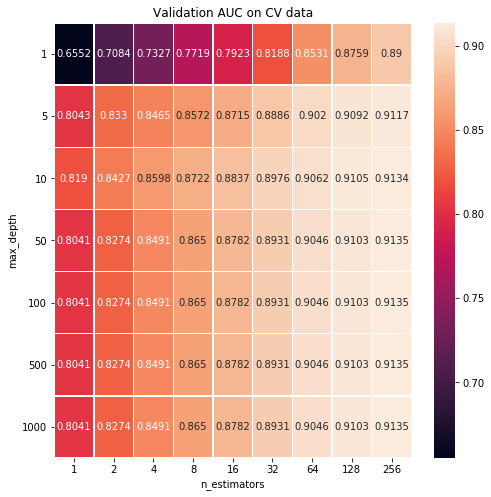

In [ ]:
scores = clf.cv_results_['mean_test_score'].reshape(
                                                     len(param_grid['max_depth']), len(param_grid['n_estimators']))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(scores, linewidths=.5, fmt='.4g',annot=True,  
                 xticklabels = n_estimators, 
                 yticklabels = max_depth)
plt.ylabel('max_depth')
plt.xlabel('n_estimators')
plt.yticks(rotation=0)
plt.title('Validation AUC on CV data')
plt.show()

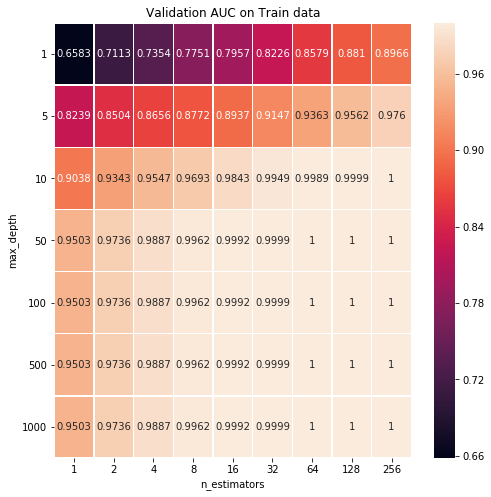

In [ ]:
scores = clf.cv_results_['mean_train_score'].reshape(
                                                     len(param_grid['max_depth']), len(param_grid['n_estimators']))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(scores, linewidths=.5, fmt='.4g',annot=True,  
                 xticklabels = n_estimators, 
                 yticklabels = max_depth)
plt.ylabel('max_depth')
plt.xlabel('n_estimators')
plt.yticks(rotation=0)
plt.title('Validation AUC on Train data')
plt.show()

In [ ]:
print("\n Train Score **\n")
print(clf.cv_results_['mean_train_score'].reshape(len(param_grid['max_depth']), len(param_grid['n_estimators'])))
print("\n CV Score **\n")
print(clf.cv_results_['mean_test_score'].reshape(len(param_grid['max_depth']), len(param_grid['n_estimators'])))



 Train Score **

[[0.65827355 0.71133642 0.73536724 0.77506749 0.79574569 0.82264185
  0.85792686 0.88101811 0.89661079]
 [0.82387378 0.85043232 0.86557194 0.87722606 0.8936785  0.91468463
  0.93629633 0.9562193  0.97598447]
 [0.90380168 0.93433587 0.95465033 0.96934287 0.98430153 0.99492085
  0.99893782 0.99992148 0.99999652]
 [0.95031805 0.97362442 0.98872759 0.99616835 0.99917122 0.99993611
  0.99999409 0.99999765 0.99999765]
 [0.95031805 0.97362442 0.98872759 0.99616835 0.99917122 0.99993611
  0.99999409 0.99999765 0.99999765]
 [0.95031805 0.97362442 0.98872759 0.99616835 0.99917122 0.99993611
  0.99999409 0.99999765 0.99999765]
 [0.95031805 0.97362442 0.98872759 0.99616835 0.99917122 0.99993611
  0.99999409 0.99999765 0.99999765]]

 CV Score **

[[0.65515993 0.70837154 0.7327244  0.7718892  0.79232065 0.81875152
  0.8530743  0.87585917 0.89002362]
 [0.80427224 0.83301411 0.84650215 0.85721652 0.87150569 0.88856941
  0.90196848 0.90919081 0.91171956]
 [0.81896884 0.84272786 0.8598

In [ ]:
xbg = xgb.XGBClassifier(class_weight = 'balanced', 
                            max_depth = clf.best_estimator_.get_params()['max_depth'], 
                            n_estimators = clf.best_estimator_.get_params()['n_estimators']
                           )

In [ ]:
xbg.fit(np.array(X_tr_vectors), np.array(y_tr))

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=256, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Confusion Matrix of train data 



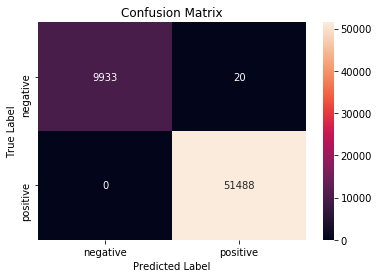

Confusion Matrix of test data 



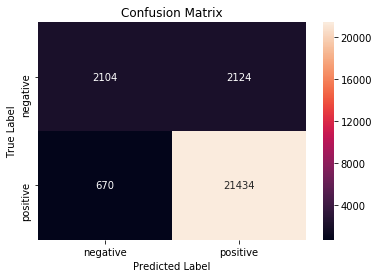

**** TEST AUC ***  0.8507925978885058
**** TRAIN AUC *****  0.8978981091880751


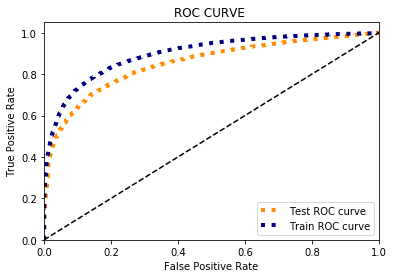

In [ ]:
print("Confusion Matrix of train data \n")
predict = xbg.predict(np.array(X_tr_vectors))
cm = metrics.confusion_matrix(y_tr, predict)
ConfusionMatrixPrint(cm)
print("Confusion Matrix of test data \n")
predict = xbg.predict(np.array(X_test_vectors))
cm = metrics.confusion_matrix(y_test, predict)
ConfusionMatrixPrint(cm)
y_cv_predict = np.array(xbg.predict_proba(X_test_vectors))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(xbg.predict_proba(X_tr_vectors))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

###<font color='green'><b>Text Encoding using TFIDF W2V

In [ ]:
clf = GridSearchCV(estimator = xgb.XGBClassifier(class_weight = 'balanced'), param_grid = param_grid, 
                   scoring = 'roc_auc', cv = 3, 
                   return_train_score = True)
clf.fit(np.array(tfidf_sent_vectors_tr), np.array(y_tr))

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000],
                         'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128, 256]},
             pre_di

In [ ]:
print('Best depth:', clf.best_estimator_.get_params()['max_depth'])
print('Best n_estimators:', clf.best_estimator_.get_params()['n_estimators'])


Best depth: 10
Best n_estimators: 256


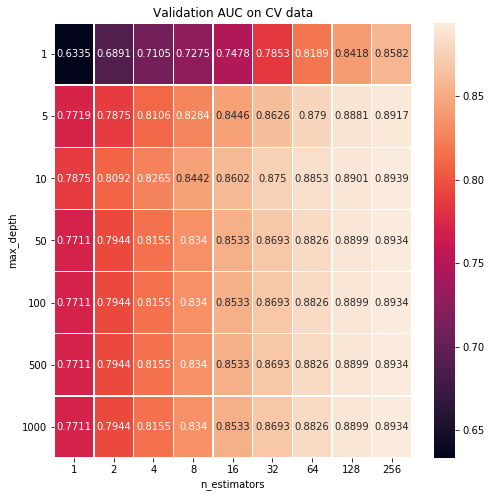

In [ ]:
scores = clf.cv_results_['mean_test_score'].reshape(
                                                     len(param_grid['max_depth']), len(param_grid['n_estimators']))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(scores, linewidths=.5, fmt='.4g',annot=True,  
                 xticklabels = n_estimators, 
                 yticklabels = max_depth)
plt.ylabel('max_depth')
plt.xlabel('n_estimators')
plt.yticks(rotation=0)
plt.title('Validation AUC on CV data')
plt.show()

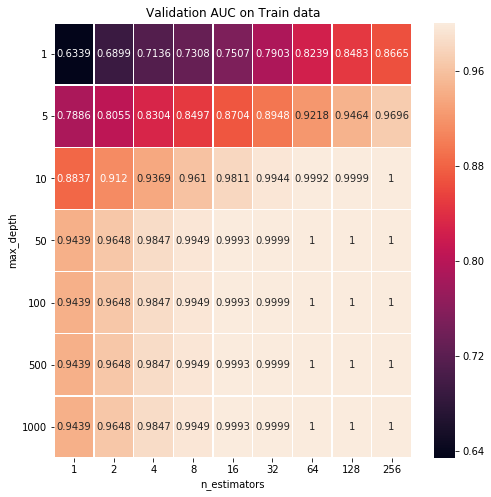

In [ ]:
scores = clf.cv_results_['mean_train_score'].reshape(
                                                     len(param_grid['max_depth']), len(param_grid['n_estimators']))
plt.figure(figsize=(8, 8))
ax = sns.heatmap(scores, linewidths=.5, fmt='.4g',annot=True,  
                 xticklabels = n_estimators, 
                 yticklabels = max_depth)
plt.ylabel('max_depth')
plt.xlabel('n_estimators')
plt.yticks(rotation=0)
plt.title('Validation AUC on Train data')
plt.show()

In [ ]:
print("\n Train Score **\n")
print(clf.cv_results_['mean_train_score'].reshape(len(param_grid['max_depth']), len(param_grid['n_estimators'])))
print("\n CV Score **\n")
print(clf.cv_results_['mean_test_score'].reshape(len(param_grid['max_depth']), len(param_grid['n_estimators'])))



 Train Score **

[[0.63392417 0.68993872 0.71355013 0.73078244 0.75068158 0.79034763
  0.82393599 0.8482718  0.86648752]
 [0.78859576 0.8054573  0.83041468 0.84968212 0.87042735 0.89479733
  0.92183074 0.94637547 0.96962605]
 [0.88365999 0.91200184 0.93687363 0.96101924 0.98113447 0.99439221
  0.99924515 0.99993257 0.99999633]
 [0.9438673  0.96475604 0.98467331 0.99487147 0.99925446 0.9999414
  0.99999475 0.99999765 0.99999765]
 [0.9438673  0.96475604 0.98467331 0.99487147 0.99925446 0.9999414
  0.99999475 0.99999765 0.99999765]
 [0.9438673  0.96475604 0.98467331 0.99487147 0.99925446 0.9999414
  0.99999475 0.99999765 0.99999765]
 [0.9438673  0.96475604 0.98467331 0.99487147 0.99925446 0.9999414
  0.99999475 0.99999765 0.99999765]]

 CV Score **

[[0.63346744 0.6891284  0.71049436 0.72747028 0.74777826 0.78528539
  0.81886185 0.84178659 0.85816521]
 [0.77190534 0.78750557 0.81056428 0.82839936 0.84457515 0.86257332
  0.87904324 0.88806806 0.89174807]
 [0.78751657 0.80924045 0.82648913

In [ ]:
xbg = xgb.XGBClassifier(class_weight = 'balanced', 
                            max_depth = clf.best_estimator_.get_params()['max_depth'], 
                            n_estimators = clf.best_estimator_.get_params()['n_estimators']
                           )

In [ ]:
xbg.fit(np.array(tfidf_sent_vectors_tr), np.array(y_tr))

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=256, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Confusion Matrix of train data 



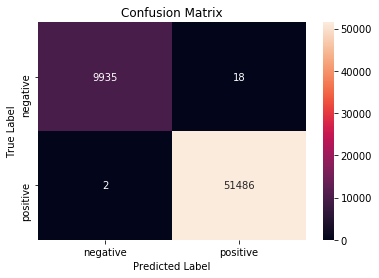

Confusion Matrix of test data 



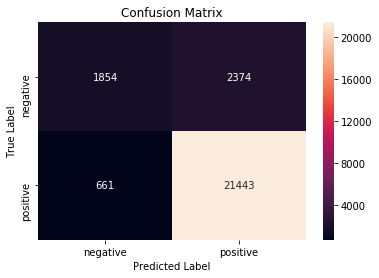

**** TEST AUC ***  0.8365342291758476
**** TRAIN AUC *****  0.9004219995179956


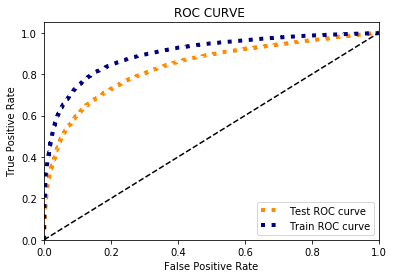

In [ ]:
print("Confusion Matrix of train data \n")
predict = xbg.predict(np.array(tfidf_sent_vectors_tr))
cm = metrics.confusion_matrix(y_tr, predict)
ConfusionMatrixPrint(cm)
print("Confusion Matrix of test data \n")
predict = xbg.predict(np.array(tfidf_sent_vectors_test))
cm = metrics.confusion_matrix(y_test, predict)
ConfusionMatrixPrint(cm)
y_cv_predict = np.array(xbg.predict_proba(tfidf_sent_vectors_test))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(xbg.predict_proba(tfidf_sent_vectors_tr))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

##<font color='green'><b>Conclusion

In [ ]:
# Please compare all your models using Prettytable library
x = PrettyTable()
x.add_column("S.NO",[1,2,3,4,5,6,7,8])
x.add_column("Model Description",["RF on Bow"," RF on Tf-IDF"," RF on Avg W2V", " RF on TF-IDF w2v","XGBoost on Bow"," XGBoost on Tf-IDF"," XGBoost on Avg W2V", " XGBoost on TF-IDF w2v", ])
x.add_column("Hyperparameter Depth",["500", "500", "500", "100", "50", "50", "50", "10"])
x.add_column("Hyperparameter Estimator",["256" , "256", "256", "256", "256" , "256", "256", "256"])
x.add_column("Test AUC",[0.932, 0.933 , 0.883, 0.863, 0.841, 0.847, 0.851, 0.836])
print(x)

+------+------------------------+----------------------+--------------------------+----------+
| S.NO |   Model Description    | Hyperparameter Depth | Hyperparameter Estimator | Test AUC |
+------+------------------------+----------------------+--------------------------+----------+
|  1   |       RF on Bow        |         500          |           256            |  0.932   |
|  2   |      RF on Tf-IDF      |         500          |           256            |  0.933   |
|  3   |      RF on Avg W2V     |         500          |           256            |  0.883   |
|  4   |    RF on TF-IDF w2v    |         100          |           256            |  0.863   |
|  5   |     XGBoost on Bow     |          50          |           256            |  0.841   |
|  6   |    XGBoost on Tf-IDF   |          50          |           256            |  0.847   |
|  7   |   XGBoost on Avg W2V   |          50          |           256            |  0.851   |
|  8   |  XGBoost on TF-IDF w2v |          10     